Number of stops with 'Berlin' in their name: 19273


Computing A* Paths: 100%|██████████| 100000/100000 [05:14<00:00, 317.50it/s]


Removing isolated nodes


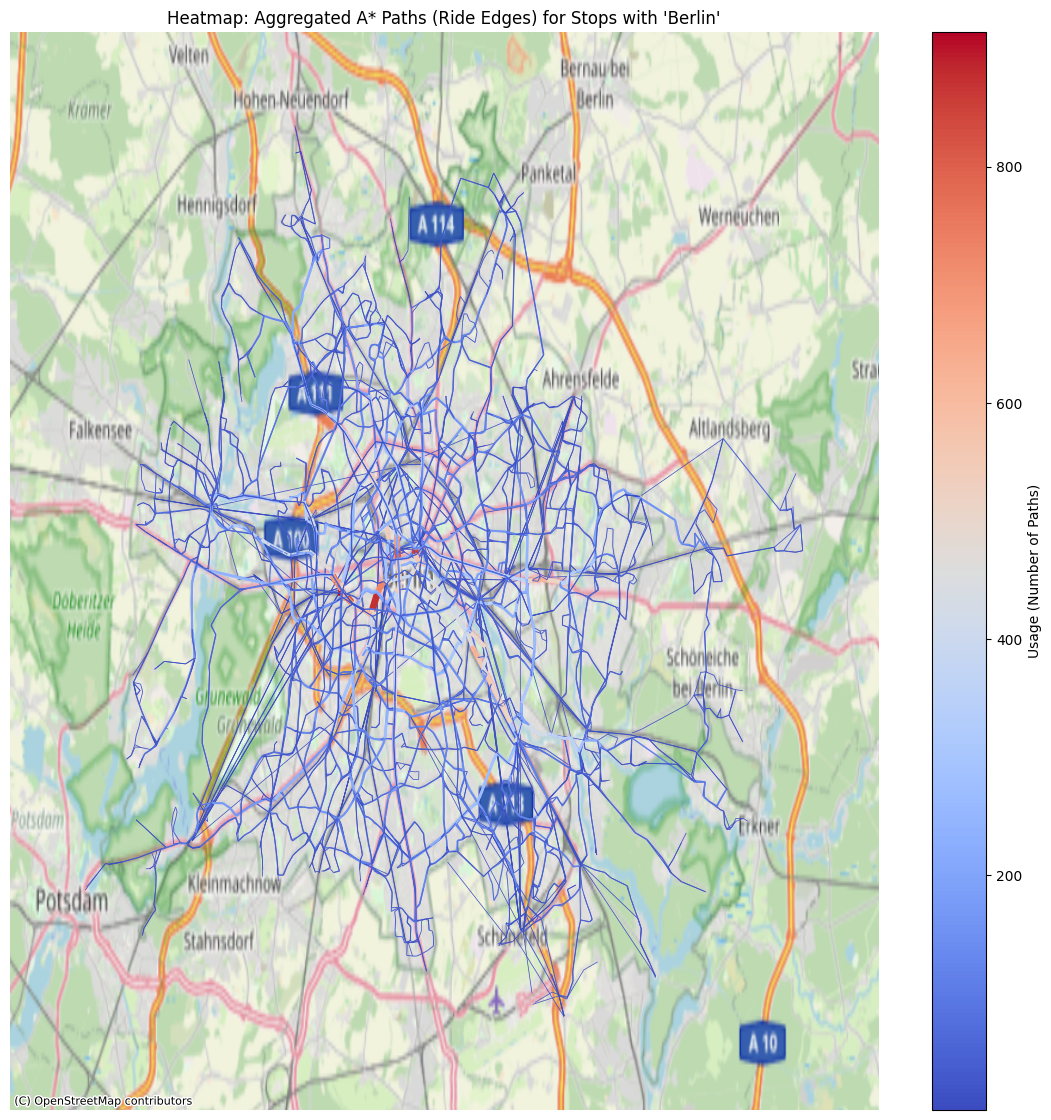

In [ ]:
import pandas as pd
import networkx as nx
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import pickle
import contextily as ctx
from collections import defaultdict
import matplotlib.cm as cm
from tqdm import tqdm

#########################################
# Helper Functions
#########################################
DATA_PATH = "../datasets"

def haversine(lon1, lat1, lon2, lat2):
    """Calculate the Haversine distance (in kilometers) between two points."""
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    return c * 6371  # Earth radius in km

def heuristic_state(state, goal, stops_dict):
    """
    Heuristic for A*: Haversine distance between the stops in state and goal.
    state, goal: Tuple (stop_id, line)
    stops_dict: Dictionary mapping stop_id to (lon, lat)
    """
    stop1, stop2 = state[0], goal[0]
    lon1, lat1 = stops_dict[stop1]
    lon2, lat2 = stops_dict[stop2]
    return haversine(lon1, lat1, lon2, lat2)

#########################################
# 1. Load GTFS Files and Filter Stops by Name (only stops with "Berlin" in stop_name)
#########################################
stops = pd.read_csv("berlin_gtfs/stops.txt", low_memory=False)       # Contains stop_id, stop_name, stop_lat, stop_lon, parent_station, etc.
routes = pd.read_csv("berlin_gtfs/routes.txt", low_memory=False)     # Contains route_id, route_short_name, etc.
trips = pd.read_csv("berlin_gtfs/trips.txt", low_memory=False)       # Contains trip_id, route_id, etc.
stop_times = pd.read_csv("berlin_gtfs/stop_times.txt", low_memory=False)  # Contains trip_id, stop_id, stop_sequence, etc.

# Filter stops: only keep stops where "Berlin" appears in stop_name (case_insensitive)
berlin_stops = stops[stops['stop_name'].str.contains("Berlin", na=False, case=False)].copy()
print(f"Number of stops with 'Berlin' in their name: {len(berlin_stops)}")

# Create a set of stop_ids from the filtered stops
berlin_stop_ids = set(berlin_stops['stop_id'])

# Filter stop_times to include only stops in our filtered set
stop_times = stop_times[stop_times['stop_id'].isin(berlin_stop_ids)]

# Merge trips with routes to obtain line information (e.g. route_short_name)
trips = trips.merge(routes[['route_id', 'route_short_name']], on="route_id", how="left")

# Merge stop_times with trips to attach line information to each record and sort by trip and sequence
stop_times = stop_times.merge(trips[['trip_id', 'route_short_name']], on="trip_id", how="left")
stop_times = stop_times.sort_values(by=["trip_id", "stop_sequence"])

#########################################
# 2. Build Base Network (Construct "ride" edges based solely on GTFS connections)
#########################################
edge_lines = defaultdict(set)  # Maps (stop1, stop2) to the set of lines serving that edge
node_lines = defaultdict(set)  # Maps stop to the set of lines that serve it

# Process each trip (with tqdm progress)
for trip_id, group in tqdm(list(stop_times.groupby("trip_id")), desc="Processing Trips"):
    group = group.sort_values("stop_sequence")
    stops_in_trip = group['stop_id'].tolist()
    line = group['route_short_name'].iloc[0]  # All stops in this trip share the same line
    for stop in stops_in_trip:
        node_lines[stop].add(line)
    # Only connect in the given (GTFS) direction
    for i in range(len(stops_in_trip) - 1):
        s1, s2 = stops_in_trip[i], stops_in_trip[i+1]
        edge_lines[(s1, s2)].add(line)

#########################################
# 3. Build the State-Space Graph with Ride-Edges
#########################################
G_state = nx.DiGraph()

# Create nodes as (stop_id, line)
for stop, lines in node_lines.items():
    for line in lines:
        G_state.add_node((stop, line))

# Add directed Ride-Edges based solely on GTFS connections
for (s1, s2), lines in edge_lines.items():
    for line in lines:
        if G_state.has_node((s1, line)) and G_state.has_node((s2, line)):
            # Get coordinates from berlin_stops
            lon1, lat1 = berlin_stops.loc[berlin_stops.stop_id == s1, ['stop_lon', 'stop_lat']].iloc[0]
            lon2, lat2 = berlin_stops.loc[berlin_stops.stop_id == s2, ['stop_lon', 'stop_lat']].iloc[0]
            cost = haversine(float(lon1), float(lat1), float(lon2), float(lat2))
            G_state.add_edge((s1, line), (s2, line), weight=cost, edge_type="ride")

#########################################
# 4. Add Transfer Edges Based on Parent Station Information
#########################################
# Create an effective parent mapping: if a stop has a parent_station, use it;
# otherwise, use the stop_id itself.
parent_map = {}
for idx, row in berlin_stops.iterrows():
    stop_id = row['stop_id']
    parent = row.get('parent_station', None)
    if pd.isna(parent) or parent == "":
        parent_map[stop_id] = stop_id
    else:
        parent_map[stop_id] = parent

# Group state-space nodes by effective parent station
parent_nodes = defaultdict(list)
for node in G_state.nodes():
    stop, line = node
    parent = parent_map.get(stop, stop)
    parent_nodes[parent].append(node)

transfer_cost = 1.0  # Fixed cost for transfers
# Add bidirectional transfer edges only among nodes (stop, line) sharing the same effective parent station.
for parent, nodes in parent_nodes.items():
    if len(nodes) > 1:
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                u = nodes[i]
                v = nodes[j]
                G_state.add_edge(u, v, weight=transfer_cost, edge_type="transfer")
                G_state.add_edge(v, u, weight=transfer_cost, edge_type="transfer")

#########################################
# 5. A* Search in the State-Space with Random Start and Goal
#########################################
# Build a dictionary mapping stop_id to (lon, lat)
stops_dict = {row['stop_id']: (float(row['stop_lon']), float(row['stop_lat'])) 
              for idx, row in berlin_stops.iterrows()}
station_names_map = dict(zip(berlin_stops['stop_id'], berlin_stops['stop_name']))

def compute_astar_path(G_state, start_state, goal_state):
    """Compute the A* path from start_state to goal_state in the state-space graph."""
    try:
        return nx.astar_path(
            G_state, start_state, goal_state,
            heuristic=lambda u, v: heuristic_state(u, v, stops_dict),
            weight="weight"
        )
    except nx.NetworkXNoPath:
        return None

# Aggregate ride-edge usage over many random A* path computations.
num_paths = 1_000_000  # Adjust as needed (e.g., 10 million for final run)
ride_edge_counts = defaultdict(int)

all_paths = list()
for i in tqdm(range(num_paths), desc="Computing A* Paths"):
    start_stop = random.choice(list(berlin_stop_ids))
    end_stop = random.choice(list(berlin_stop_ids))
    while end_stop == start_stop:
        end_stop = random.choice(list(berlin_stop_ids))
        
    start_lines = list(node_lines[start_stop])
    end_lines = list(node_lines[end_stop])
    if not start_lines or not end_lines:
        continue  # Skip if no line is available
    
    start_state = (start_stop, random.choice(start_lines))
    goal_state = (end_stop, random.choice(end_lines))
    
    path = compute_astar_path(G_state, start_state, goal_state)
    if path is None:
        continue
    
    path_station_names = np.array([station_names_map[node[0]] for node in path])
    # Remove consecutive duplicates using a boolean mask (if path is not empty)
    if path_station_names.size > 0:
        mask = np.concatenate(([True], path_station_names[1:] != path_station_names[:-1]))
        cleaned_path = path_station_names[mask]
        all_paths.append(cleaned_path)

    # all_paths.append(cleaned_path)

    # Count each ride edge used (direction matters)
    for j in range(len(path) - 1):
        u, v = path[j], path[j+1]
        edge_data = G_state.get_edge_data(u, v)
        if edge_data and edge_data.get("edge_type") == "ride":
            ride_edge_counts[(u[0], v[0])] += 1

# Save Paths to Pickle File
with open(f'{DATA_PATH}/paths.pkl', 'wb') as f:
    pickle.dump(all_paths, f)
print(f"Saved {len(all_paths)} paths to paths.pkl")

#########################################
# 6. Plot Heatmap of the Base Network
#########################################
G_base = nx.Graph()

# Add all filtered stops as nodes with positions.
for idx, row in berlin_stops.iterrows():
    G_base.add_node(row['stop_id'], pos=(float(row['stop_lon']), float(row['stop_lat'])), name=row.get('stop_name', ""))

# Add edges from aggregated ride_edge_counts.
for (s1, s2), count in ride_edge_counts.items():
    lon1, lat1 = stops_dict[s1]
    lon2, lat2 = stops_dict[s2]
    dist = haversine(lon1, lat1, lon2, lat2)
    # For visualization, use an undirected edge.
    G_base.add_edge(s1, s2, weight=dist, count=count)

# Remove isolated nodes (stations with no connection)
isolated_nodes = list(nx.isolates(G_base))
if isolated_nodes:
    print("Removing isolated nodes")
    G_base.remove_nodes_from(isolated_nodes)

# Prepare visualization: color and width based on usage.
edges = list(G_base.edges())

counts = np.array([G_base[u][v].get("count", 0) for u, v in edges])
norm_counts = counts / counts.max() if counts.max() > 0 else counts

cmap = plt.get_cmap('coolwarm')
edge_colors = [cmap(norm) for norm in norm_counts]
min_width, max_width = 0.5, 5
edge_widths = min_width + (max_width - min_width) * norm_counts

pos = nx.get_node_attributes(G_base, 'pos')

fig, ax = plt.subplots(figsize=(14, 14))
# nx.draw_networkx_nodes(G_base, pos, node_size=30, node_color="lightblue", ax=ax)
nx.draw_networkx_edges(G_base, pos, edge_color=edge_colors, width=edge_widths, ax=ax)
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.OpenStreetMap.DE)
ax.set_title("Heatmap: Aggregated A* Paths (Ride Edges) for Stops with 'Berlin'")
ax.axis("off")

sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=counts.min(), vmax=counts.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Usage (Number of Paths)")
plt.savefig("heatmap.pdf", format="pdf")
plt.show()
